# Deep Learning with Keras

### Step 1: Install Keras

In [56]:
# INSTALLS
!pip install -q scikeras tensorflow requests certifi


### Step 2: Imports

In [57]:
import pandas as pd
import numpy as np
import requests, certifi
from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier


### Step 3: Load the data

In [58]:
# Load the Adult data into a Pandas Dataframe.
# Ensure the dataset has properly named columns. Display the first five rows.

DATA_PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
columns = [
    'age','workclass','fnlwgt','education','education-num',
    'marital-status','occupation','relationship','race','sex',
    'capital-gain','capital-loss','hours-per-week','native-country','income'
]


### Step 4: Load data into a dataframe

In [59]:
# SSL FIX: download with verified certificate
response = requests.get(DATA_PATH, verify=certifi.where())
response.raise_for_status()
df = pd.read_csv(StringIO(response.text), header=None, names=columns, na_values=' ?', skipinitialspace=True)

### Step 5: Show first rows of the data

In [60]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Step 6: Basic EDA

In [61]:
# Do some exploratory analysis. How many rows/columns are there? How are NULL
# values represented? What's the percentage of positive cases in the dataset?

print("Shape (rows, cols):", df.shape)
print("\nNULLs per column:\n", df.isnull().sum())
print("\nIncome distribution (%):\n", (df['income'].value_counts(normalize=True)*100).round(2))


Shape (rows, cols): (32561, 15)

NULLs per column:
 age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

Income distribution (%):
 income
<=50K    75.92
>50K     24.08
Name: proportion, dtype: float64


### Step 7: Find all NULL values and drop them

In [62]:
# Find all NULL values and drop them

df = df.dropna()
print("Shape after dropping NULLs:", df.shape)

Shape after dropping NULLs: (32561, 15)


### Step 8: Use the LabelEncoder and convert the income column with a data type str to a binary variable

In [63]:
# Use Scikit-Learn's LabelEncoder to convert the income column with a data type
# string to a binary variable.

le = LabelEncoder()
df['income'] = le.fit_transform(df['income'])   # <=50K -> 0, >50K -> 1
df['income'].value_counts()


income
0    24720
1     7841
Name: count, dtype: int64

### Step 9: Split the dataset into training / test sets

In [64]:
# Split dataset into training and test sets

X = df.drop(columns=['income'])
y = df['income'].astype('float32')

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_raw.shape, X_test_raw.shape


((26048, 14), (6513, 14))

### Step 10: Use Scikit-Learn for ROC AUC Score

In [65]:
# Use Scikit-Learn's roc_auc_score to calculate the AUC score for a method that
# always predicts the majority class.

majority = int(y_train.mode()[0])
y_score_majority = np.full_like(y_test, fill_value=float(majority), dtype='float32')
print("Baseline (majority) AUC:", roc_auc_score(y_test, y_score_majority))

Baseline (majority) AUC: 0.5


### Step 11: ColumnTransformer to apply one hot encoding

In [66]:
# Use Scikit-Learn's ColumnTransformer to apply One Hot Encoding to the
# categorical variables in workclass, education, marital-status, occupation,
# relationship, 'race', sex, and native-country. #Also, apply MinMaxScaler to
# the remaining continuous features.

categorical = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
numerical   = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']

preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical),
        ("scale", MinMaxScaler(), numerical),
    ]
)

_ = preprocessor.fit(X_train_raw)
n_ohe = len(preprocessor.named_transformers_["onehot"].get_feature_names_out(categorical))
n_total = n_ohe + len(numerical)
print("How many columns after transformation? ->", n_total)


How many columns after transformation? -> 108


### Step 12: How many cols will the dataframe have after these transformations?

In [67]:
# Get feature names after transformation
ohe = preprocessor.named_transformers_['onehot']
num_ohe_features = len(ohe.get_feature_names_out(categorical))
num_numeric_features = len(numerical)

total_columns = num_ohe_features + num_numeric_features
print("Total columns after transformation:", total_columns)

Total columns after transformation: 108


### Step 13: Define the Keras model

In [68]:
# Define the Keras model

def build_keras_model(meta=None):
    n_features = meta.get("n_features_in_", None) if meta else None
    model = Sequential()
    if n_features is not None:
        model.add(Dense(64, activation='relu', input_shape=(n_features,)))
    else:
        model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


### Step 14: Create the Keras Classifier

In [69]:
# Create a Keras classifier

clf = KerasClassifier(
    model=build_keras_model,
    epochs=5,
    batch_size=256,
    verbose=1
)


In [70]:
# Create the scikit-learn pipeline

pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf",  clf)
])


In [71]:
# Fit the pipeline on the training data

pipe.fit(X_train_raw, y_train)


Epoch 1/5


/Users/zinkii/Software Projects/ML Bootcamp/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8079 - loss: 0.4072
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8349 - loss: 0.3520
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8398 - loss: 0.3430
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8424 - loss: 0.3371
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8435 - loss: 0.3339


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('scale', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [72]:
# Calculate the AUC score of your model on the test data.
# Does the model predict better than random?

y_proba = pipe.predict_proba(X_test_raw)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print("Test AUC:", round(auc, 4))


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test AUC: 0.9027


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/Users/zinkii/Software Projects/ML Bootcamp/.venv/lib/python3.11/site-packages/sklearn/metrics/_plot/roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


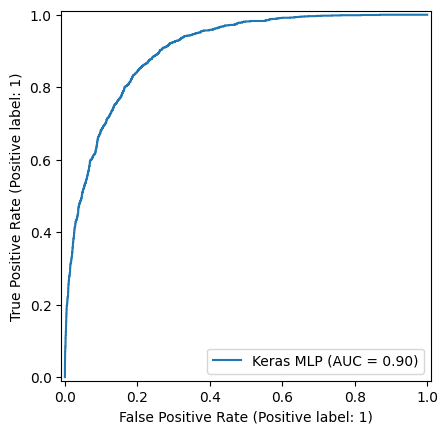

In [73]:
# get probabilities from your fitted pipeline
proba = pipe.predict_proba(X_test_raw)
# handle either shape (n,) or (n,2)
y_score = proba[:, 1] if proba.ndim == 2 and proba.shape[1] > 1 else np.ravel(proba)

RocCurveDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_score,
    name="Keras MLP"
);